# This file contains code for Appendix A

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Description

In [3]:
df_id=pd.read_csv('../Data/Most_popular_id_2019_2021.csv').iloc[:,[0,1,2,4]].astype(str)
articles=pd.read_csv('../Data/articles_data.csv')
articles.shape

(13688, 21)

## For Table A1

In [4]:
descr=articles.describe(percentiles=[], include=object).T
#print(descr.to_latex(caption='Metadata fields description', label='metadata', ))
descr

,count,unique,top,freq
link,13687,13687,https://www.nytimes.com/2019/03/07/opinion/eur...,1
headline_main,13688,13684,The Year in Charts,2
abstract,13552,13527,And what else you need to know today.,9
snippet,13424,13399,And what else you need to know today.,9
lead_paragraph,13457,12991,To hear more audio stories from publishers lik...,83
print_section,10529,33,A,6173
print_page,10532,66,1,2987
source,13554,4,The New York Times,13542
pub_date,13554,13139,2020-11-13T10:00:21+0000,4
document_type,13554,3,article,13380


## Figure A1 (left) and A3 (right)

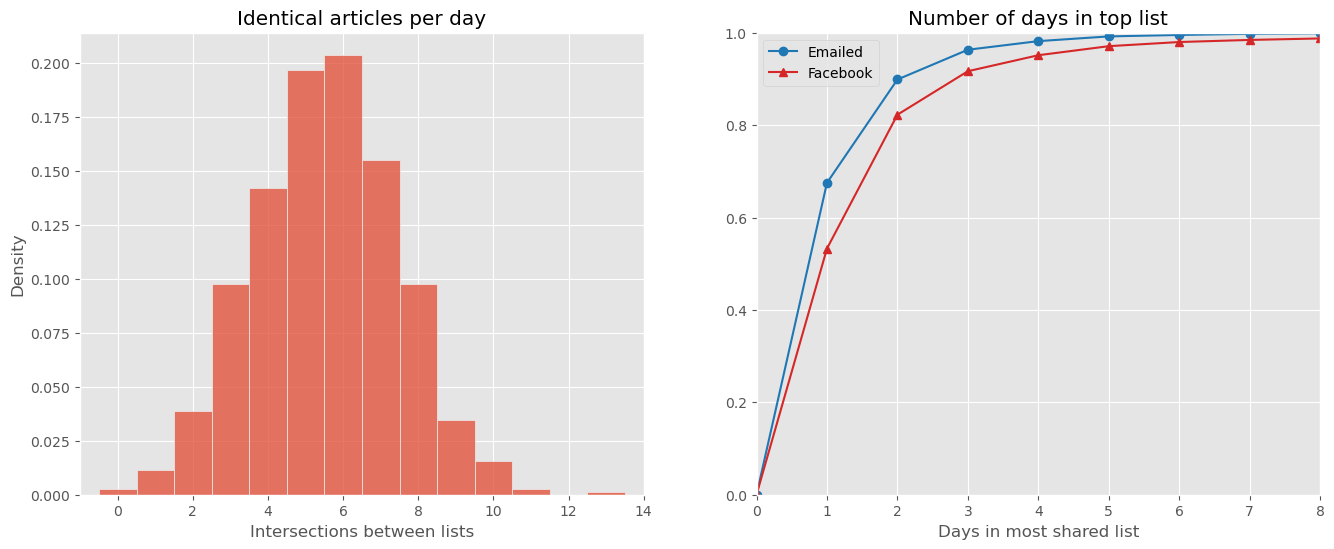

In [5]:
df=pd.read_csv('../Data/Most_popular_id_2019_2021.csv')
df.head()
types=['emailed', 'facebook']
fig, axs = plt.subplots(figsize=(16, 6),nrows=1, ncols=2) #, sharey=True 
titles=['Identical articles per day', 'Identical articles×rank per day']

#first
dates=df['date'].unique()
intersections=[]
for date in dates:
    st=set(df[df['date']==date]['id_'+types[0]]).intersection(set(df[df['date']==date]['id_'+types[1]]))
    intersections.append(len(st))

sns.histplot(intersections, ax=axs[0], discrete = True, stat="density")
axs[0].set_xlim(-1,14)
axs[0].set_xlabel('Intersections between lists')
axs[0].set_title('Identical articles per day')

#second
for i in range(2):
    l=list(df['id_'+types[i]])
    a=[l.count(x) for x in set(l)]
    values, counts = np.unique(a, return_counts=True)
    
    axs[1].plot([0]+list(values), [0]+list(np.cumsum(counts/sum(counts))), 
                color=['tab:blue', 'tab:red'][i], marker=['o', '^'][i]) #linestyle=['solid','dashed'][i],
    axs[1].set_ylim(0,1)

axs[1].set_xlabel('Days in most shared list')
axs[1].set_title('Number of days in top list')
axs[1].legend(["Emailed", "Facebook"])
axs[1].set_xlim(0,8)
plt.show()

Every article counted as much times as it appears in daily data

## Figure A2a

In [6]:
popular=pd.read_csv('../Data/Most_popular_id_2019_2021.csv')
articles=pd.read_csv('../Data/articles_data.csv')
link_type=['id_emailed', 'id_facebook']
titles=['Most emailed', 'Most shared on Facebook']
df_list=[pd.merge(popular, articles, how="inner", left_on=clmn, right_on='id').loc[:, ['id','word_count']] 
         for clmn in link_type]
for i in range(2):
    df_list[i]=df_list[i][df_list[i]['word_count']!=0.0]

In [7]:
link_type=['id_emailed', 'id_facebook']
a_data=pd.read_csv('../Data/articles_data.csv')
df_list=[pd.merge(popular, a_data, how="inner", left_on=clmn, right_on='id').loc[:, 
                ['id','section_name', 'news_desk', 'type_of_material', 'document_type']] for clmn in link_type]

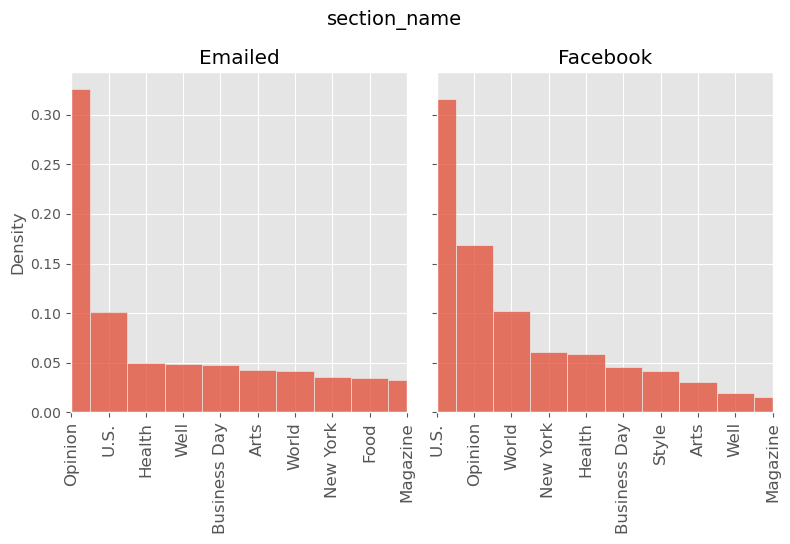

In [8]:
def plot_hist_if(column_name, amount=10, unique=False):
    #print(column_name)
    fig, axs = plt.subplots(figsize=(8, 5.5),nrows=1, ncols=2, sharey=True) 
    for i in range(2):
        a=df_list[i].loc[:,['id',column_name]]
        if unique:
            a=a.drop_duplicates(subset='id', keep='first', ignore_index=True)
        a=a[~a[column_name].isna()]
        freq=[[sum(a[column_name]==name),name] for name in a[column_name].unique()]
        freq.sort(key=lambda x: x[0], reverse=True)
        new_lst_of_names=[x[1] for x in freq for i in range(x[0])]
        sns.histplot(new_lst_of_names, stat="density", ax=axs[i], hue_order=[x[1] for x in freq], )
        axs[i].set_title(['Emailed', 'Facebook'][i])
        axs[i].set_xlim((0,amount))
        axs[i].tick_params(axis='x', labelrotation=90, labelsize='large')
    fig.suptitle(column_name, fontsize=14)
    fig.tight_layout() 
    plt.show()


for column_name, i in zip(['section_name'], [9,9]): 
    plot_hist_if(column_name, i)

## Figure A2b

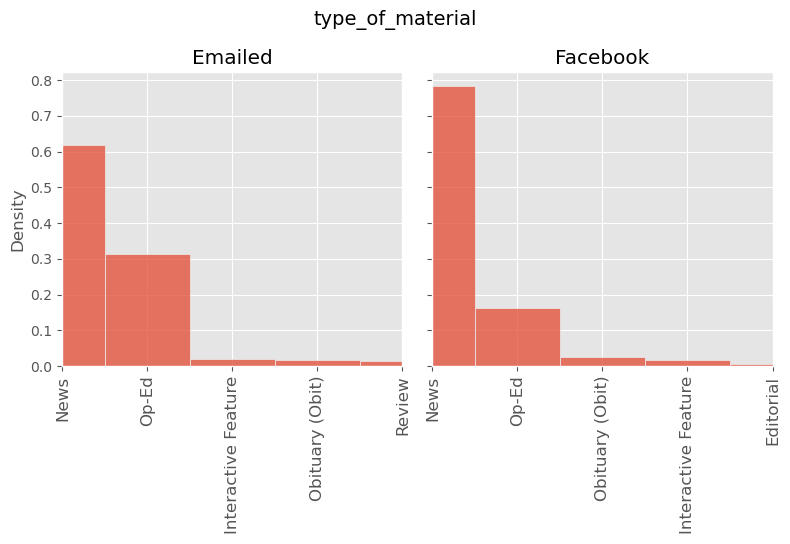

In [9]:
for column_name, i in zip(['type_of_material'], [4,4]):
    plot_hist_if(column_name, i)